### Example: MovieLens dataset

We will use R package [recommenderlab](https://cran.r-project.org/web/packages/recommenderlab/index.html) <cite data-cite="recommenderlab"></cite> and __100k-MovieLense__ dataset. The data was collected through the MovieLens web site
(movielens.umn.edu) during Sept 1997 - Apr 1998. The data set contains ~100k ratings (1-5) from 943 users on 1664 movies. Each user has rated at least 19 movies. Note that the ratings matrix is stored with users corresponding to rows and movies corresponding to columns (different from what we had in the lectures).

In [2]:
library(recommenderlab)
data(MovieLense)
MovieLense
nusers=dim(MovieLense)[1]
nmovies=dim(MovieLense)[2]

943 x 1664 rating matrix of class ‘realRatingMatrix’ with 99392 ratings.

In [3]:
#check how many movies have the users rated
summary(rowCounts(MovieLense))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   19.0    32.0    64.0   105.4   147.5   735.0 

In [4]:
MovieLenseMeta[1:5,1:10] #metadata about movies (feature vectors) are also available - we don't use them here!

title,year,url,unknown,Action,Adventure,Animation,Children's,Comedy,Crime
Toy Story (1995),1995,http://us.imdb.com/M/title-exact?Toy%20Story%20(1995),0,0,0,1,1,1,0
GoldenEye (1995),1995,http://us.imdb.com/M/title-exact?GoldenEye%20(1995),0,1,1,0,0,0,0
Four Rooms (1995),1995,http://us.imdb.com/M/title-exact?Four%20Rooms%20(1995),0,0,0,0,0,0,0
Get Shorty (1995),1995,http://us.imdb.com/M/title-exact?Get%20Shorty%20(1995),0,1,0,0,0,1,0
Copycat (1995),1995,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1


We can visualise a part of the ratings matrix. There is lots of missing data!

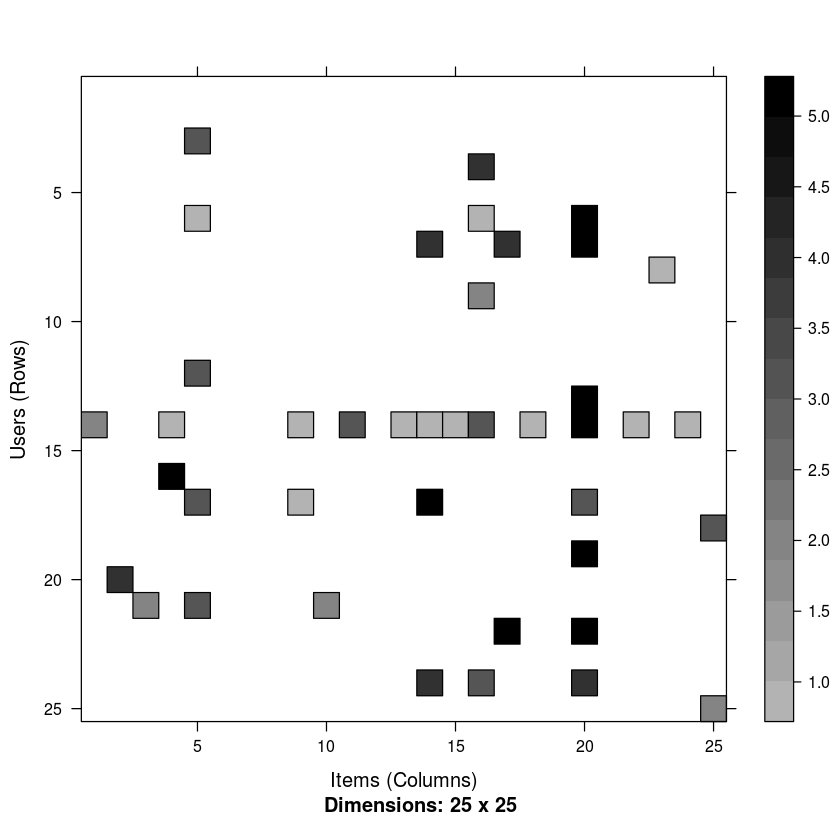

In [5]:
image(MovieLense[sample(nusers,25),sample(nmovies,25)])

We will next run user-based collaborative filtering (UBCF), item-based collaborative filtering (IBCF) and alternating least squares (ALS) on this dataset. Let us first prepare the dataset. Users are split into a training set ($90\%$) and a test set ($10\%$). Thus, we will train our models on the ratings of 848 users. On the test set of 95 users, 12 ratings per user will be given to the recommender to make predictions and the other ratings are held out for computing prediction accuracy.

In [6]:
## create 90/10 split (known/unknown)
evlt <- evaluationScheme(MovieLense, method="split", train=0.9,
                         given=12)
evlt
tr <- getData(evlt, "train"); tr
tst_known <- getData(evlt, "known"); tst_known
tst_unknown <- getData(evlt, "unknown"); tst_unknown

Evaluation scheme with 12 items given
Method: ‘split’ with 1 run(s).
Training set proportion: 0.900
Good ratings: NA
Data set: 943 x 1664 rating matrix of class ‘realRatingMatrix’ with 99392 ratings.

848 x 1664 rating matrix of class ‘realRatingMatrix’ with 88557 ratings.

95 x 1664 rating matrix of class ‘realRatingMatrix’ with 1140 ratings.

95 x 1664 rating matrix of class ‘realRatingMatrix’ with 9695 ratings.

Create a UBCF recommender, using Pearson similarity and 50 nearest neighbours. 

In [7]:
## create a user-based CF recommender using training data
rcmnd_ub <- Recommender(tr, "UBCF",
                        param=list(method="pearson",nn=50))

## create predictions for the test users using known ratings
pred_ub <- predict(rcmnd_ub, tst_known, type="ratings"); pred_ub

## evaluate recommendations on "unknown" ratings
acc_ub <- calcPredictionAccuracy(pred_ub, tst_unknown);
as(acc_ub,"matrix")

95 x 1664 rating matrix of class ‘realRatingMatrix’ with 156940 ratings.

RMSE,1.0914818
MSE,1.1913325
MAE,0.8711042


In [8]:
#compare predictions with true "unknown" ratings
as(tst_unknown, "matrix")[1:8,1:5]
as(pred_ub, "matrix")[1:8,1:5]

,Toy Story (1995),GoldenEye (1995),Four Rooms (1995),Get Shorty (1995),Copycat (1995)
5,4,3,NA,NA,NA
6,4,NA,NA,NA,NA
7,NA,NA,NA,5,NA
13,3,3,NA,5,1
35,NA,NA,NA,NA,NA
44,4,NA,NA,NA,4
54,4,NA,NA,NA,NA
65,3,NA,NA,NA,NA


,Toy Story (1995),GoldenEye (1995),Four Rooms (1995),Get Shorty (1995),Copycat (1995)
5,2.478321,2.357157,2.336074,2.428473,2.368132
6,3.458488,3.374429,3.510538,3.429548,3.370482
7,3.859838,3.703389,3.658794,3.728707,3.717585
13,2.707438,2.584175,2.479966,2.549201,2.564746
35,2.838027,2.750989,2.745954,2.755377,2.722942
44,3.475823,3.387616,3.239503,3.332724,3.312472
54,4.007823,3.810384,3.815898,3.863014,3.807695
65,3.811664,3.641846,3.575492,3.651777,3.683020


Now, let us repeat the same thing with IBCF. On this dataset, it does not work as well.

In [9]:
## repeat with the item-based approach
rcmnd_ib <- Recommender(tr, "IBCF",
                        param=list(method="pearson",k=50))
pred_ib <- predict(rcmnd_ib, tst_known, type="ratings")
acc_ib <- calcPredictionAccuracy(pred_ib, tst_unknown) 
acc <- rbind(UBCF = acc_ub, IBCF = acc_ib); acc

,RMSE,MSE,MAE
UBCF,1.091482,1.191332,0.8711042
IBCF,1.683765,2.835066,1.2843314


We next try the alternating least squares approach (`ALS`). We will use latent attributes of dimension $k=20$. 

In [10]:
rcmnd_als <- Recommender(tr, "ALS",
                         param=list(n_factors=20))
pred_als <- predict(rcmnd_als, tst_known, type="ratings")
acc_als <- calcPredictionAccuracy(pred_als, tst_unknown) 
acc <- rbind(UBCF = acc_ub, IBCF = acc_ib, ALS = acc_als); acc

,RMSE,MSE,MAE
UBCF,1.091482,1.191332,0.8711042
IBCF,1.683765,2.835066,1.2843314
ALS,1.022098,1.044684,0.8146836


The results of ALS look favourable to those of memory-based methods. However, each method has a number of tuning parameters (type of similarity, number of neighbours, number of latent factors, regularization parameters) so further comparisons are needed. There is a number of other methods -- below we query the registry of implemented methods.

In [12]:
recommenderRegistry$get_entries(dataType = "realRatingMatrix")

$ALS_realRatingMatrix
Recommender method: ALS for realRatingMatrix
Description: Recommender for explicit ratings based on latent factors, calculated by alternating least squares algorithm.
Reference: Yunhong Zhou, Dennis Wilkinson, Robert Schreiber, Rong Pan (2008). Large-Scale Parallel Collaborative Filtering for the Netflix Prize, 4th Int'l Conf. Algorithmic Aspects in Information and Management, LNCS 5034.
Parameters:
  normalize lambda n_factors n_iterations min_item_nr seed
1      NULL    0.1        10           10           1 NULL

$ALS_implicit_realRatingMatrix
Recommender method: ALS_implicit for realRatingMatrix
Description: Recommender for implicit data based on latent factors, calculated by alternating least squares algorithm.
Reference: Yifan Hu, Yehuda Koren, Chris Volinsky (2008). Collaborative Filtering for Implicit Feedback Datasets, ICDM '08 Proceedings of the 2008 Eighth IEEE International Conference on Data Mining, pages 263-272.
Parameters:
  lambda alpha n_factors 